In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Create an Inspector to the db
from sqlalchemy import inspect

inspector = inspect(engine)

print("Columns of the measurement table \n")
#columns of the measurement table
measurementCols = inspector.get_columns('measurement')
for mCol in measurementCols:
    print(mCol['name'], mCol['type'])
    

print("\nColumns of the Station table \n")
#columns of the station table
stationCols = inspector.get_columns('station')
for sCol in stationCols:
    print(sCol['name'], sCol['type'])

Columns of the measurement table 

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Columns of the Station table 

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# #print the data for the measurement table
# print("\nMeasurement Table Data")

# for thisClass in Base.classes.keys():
#     print("\nclass %s \n" %thisClass)
#     data = engine.execute(f"SELECT * FROM {thisClass} LIMIT 5").fetchall()
#     print(data)

# Exploratory Climate Analysis

Date 1 year ago from the Last Date 2017-08-23 in the DB: 2016-08-23
SELECT measurement.date, measurement.prcp 
FROM measurement 
WHERE measurement.date >= :date_1 AND measurement.date <= :date_2


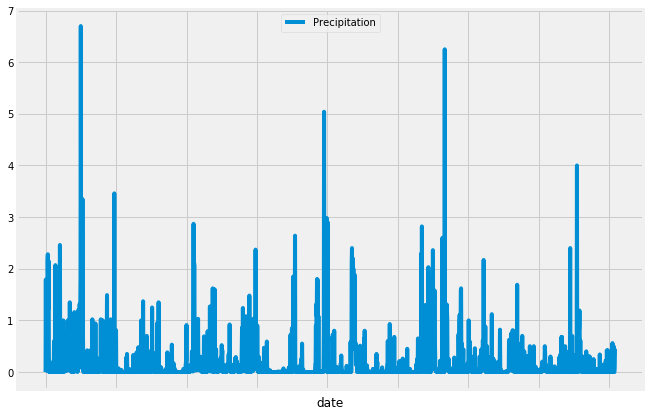

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastDateDT = dt.datetime.strptime(lastDate[0], '%Y-%m-%d').date()
date12Delta = lastDateDT - dt.timedelta(days=365)
print("Date 1 year ago from the Last Date %s in the DB: %s" %(lastDateDT, str(date12Delta)))

# Perform a query to retrieve the data and precipitation scores
q = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= date12Delta).filter(Measurement.date <= lastDateDT)
print(q.statement)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(q.statement, engine.connect())
date_indx_df = df.set_index('date')

# Sort the dataframe by date
date_indx_df = date_indx_df.sort_values(by='date', axis=0)
date_indx_df = date_indx_df.dropna(how='any')

# Use Pandas Plotting with Matplotlib to plot the data
date_indx_df.plot(figsize=(10,7))
plt.legend(['Precipitation'], loc='upper center')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_indx_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# q = session.query(Measurement.date, Measurement.prcp)
# print(q) - SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp FROM measurement

# q = session.query(Measurement.date, Measurement.prcp)[0]
# print(q) - ('2010-01-01', 0.08)

In [15]:
# Design a query to show how many stations are available in this dataset?
no_of_stations = session.query(func.count(Station.station)).all()
no_of_stations

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query_active_stations = session.query(Measurement.station, func.count(Measurement.id).label('Count')).\
group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

print(f"The Stations and the counts in descending order:")
query_active_stations

The Stations and the counts in descending order:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
query_active_stations2 = session.query(Station.station, func.count(Station.id).label('Count')).\
group_by(Station.station).order_by(func.count(Station.id).desc()).all()

print(f"The Stations and the counts in descending order:")
query_active_stations2

The Stations and the counts in descending order:


[('USC00511918', 1),
 ('USC00513117', 1),
 ('USC00514830', 1),
 ('USC00516128', 1),
 ('USC00517948', 1),
 ('USC00518838', 1),
 ('USC00519281', 1),
 ('USC00519397', 1),
 ('USC00519523', 1)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
query_temp_max = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), \
                              func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
query_temp_max

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

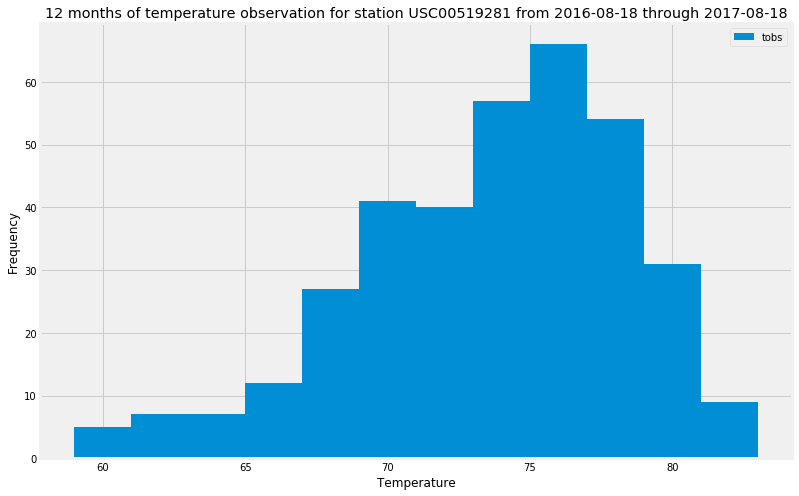

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationHT = 'USC00519281'
lastDateStatHTQ = session.query(Measurement.date).filter(Measurement.station == stationHT).\
order_by(Measurement.date.desc()).first()
lastDateStatHTQ = dt.datetime.strptime(lastDateStatHTQ[0], "%Y-%m-%d").date()
firstDateStatHTQ = lastDateStatHTQ - dt.timedelta(days=365)

tempObsQ = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > firstDateStatHTQ).\
filter(Measurement.station == stationHT)

tempObsDF = pd.read_sql(tempObsQ.statement, engine.connect())
plt.figure(figsize=(12, 8))
plt.hist(tempObsDF['tobs'],12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'12 months of temperature observation for station {stationHT} from {firstDateStatHTQ} \
through {lastDateStatHTQ}')
plt.legend(['tobs'], loc='best')
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print("Date 1 year ago from the Last Date %s in the DB: %s" %(lastDateDT, str(date12Delta)))
tripAvgTemp = calc_temps(firstDateStatHTQ, lastDateStatHTQ)
tripAvgTemp

Date 1 year ago from the Last Date 2017-08-23 in the DB: 2016-08-23


[(58.0, 74.59875167186803, 87.0)]

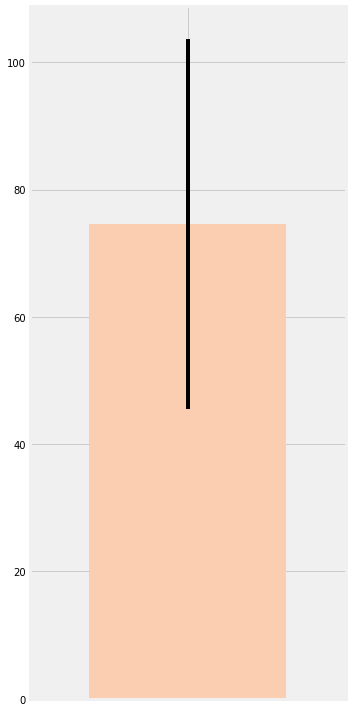

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmax = tripAvgTemp[0][2]
tmin = tripAvgTemp[0][0]
tavg = tripAvgTemp[0][1]

plt.figure(figsize=(5,10))
plt.bar(2, tavg, yerr=tmax - tmin, width=2.5, align='center', tick_label="", color='#FBCEB1')
plt.xlim(0,4)
plt.tight_layout()
plt.show()

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfallQ = session.query(Measurement.station, func.avg(Measurement.prcp).label('Precipitation'), Station.name, Station.latitude, Station.longitude, \
                         Station.elevation).filter(Measurement.station == Station.station).\
                         filter(Measurement.date >= firstDateStatHTQ).filter(Measurement.date <= lastDateStatHTQ).\
                         group_by(Measurement.station, Station.name, Station.latitude, Station.longitude, \
                                  Station.elevation).order_by(func.avg(Measurement.prcp).desc())

rainfallDF = pd.read_sql(rainfallQ.statement, engine.connect())
rainfallDF

,station,Precipitation,name,latitude,longitude,elevation
0,USC00516128,0.459574,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,0.204118,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,0.143506,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,0.126098,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,0.122208,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00517948,0.075246,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,USC00519397,0.046379,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


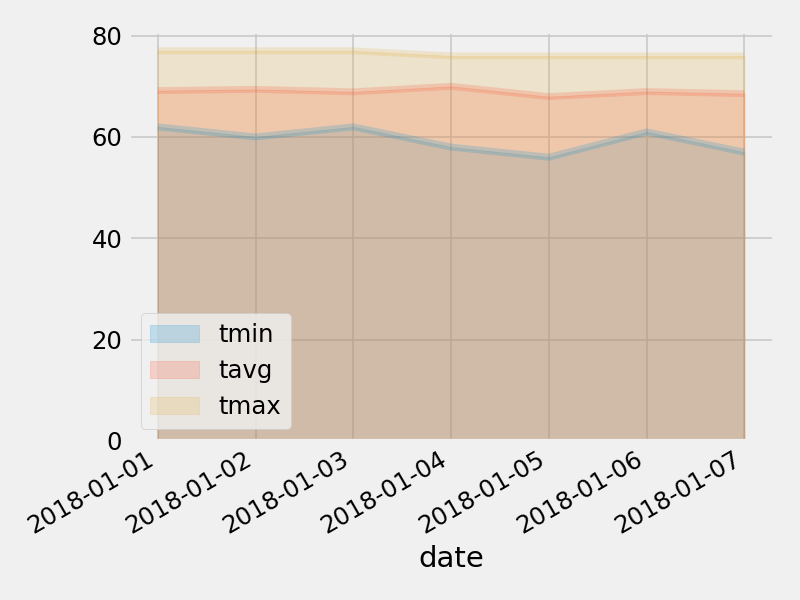

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
